In [12]:
%matplotlib inline

import os
import numpy as np
import pylab as py
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

main_dir = os.getcwd() + r'\\'
data_name = main_dir + 'match_vectors_no_label.csv'
shuffled = True
shuffled_data_name = main_dir + 'match_vectors_no_label_shuffled.csv'

FEATURE_LABEL = ['h_roster_rating', 'h_gk_rating', 'h_def_rating', 'h_mid_rating', 'h_off_rating',
                 'a_roster_rating', 'a_gk_rating', 'a_def_rating', 'a_mid_rating', 'a_off_rating',
                 'label']

print("Environment setup done. Ready to proceed.")


Environment setup done. Ready to proceed.


In [13]:
def add_x0(x):
    return_x = np.zeros((x.shape[0], x.shape[1] + 1))
    return_x[:, 0] = 1
    return_x[:, 1:] = x
    return return_x

def define_xy(data, L_i, ratio=0.8, draw_is_loss=True):
    print(f"Label mapping draw_is_loss={draw_is_loss} for features={L_i} with ratio={ratio}")
    x = np.copy(add_x0(data[:, L_i]))
    y = np.copy(data[:, -1])
    i_split = int(len(y) * ratio)
    if draw_is_loss:
        print("Mapping draw as loss")
        for i in range(i_split):
            if y[i] < 1:
                y[i] = 0
    else:
        print("Mapping draw as win")
        for i in range(i_split):
            if y[i] >= 0:
                y[i] = 0
            else:
                y[i] = 1
    x_train, x_test = x[:i_split, :], x[i_split:, :]
    y_train, y_test = y[:i_split], y[i_split:]
    print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}, x_test shape: {x_test.shape}, y_test shape: {y_test.shape}")
    return x_train, y_train, x_test, y_test


In [14]:
def h_logreg(x_i, theta):
    return 1. / (1 + np.exp(-x_i.dot(theta)))

def grad_l(x, y, theta, lmda=1e1):
    h = 1. / (1 + np.exp(-x.dot(theta)))
    grad = (y - h).dot(x)
    return grad - lmda * theta

def logreg(x, y, eps=1e-15, alpha=1e-5, lmda=1e1):
    d = len(x[0])
    theta = np.zeros(d)
    itr = 0
    while True:
        itr += 1
        prev_theta = theta
        theta = theta + alpha * grad_l(x, y, theta, lmda=lmda)
        eps_i = np.linalg.norm(prev_theta - theta)
        if itr % 10000 == 0:
            print(f"Iteration {itr}: norm diff {eps_i}")
        if eps_i < eps:
            print(f"Converged at iteration {itr} with norm diff {eps_i}")
            break
    return theta

def plot_prediction(x_test, y_test, theta_d_is_win, theta_d_is_loss, title=''):
    print(f"Plotting predictions for {title}")
    h, y_predict = [], []
    for i in range(len(y_test)):
        h_i_win = h_logreg(x_test[i, :], theta_d_is_loss)
        h_i_loss = h_logreg(x_test[i, :], theta_d_is_win)
        h.append(h_i_loss)
        if h_i_win >= 0.5:
            y_predict.append(1)
        elif h_i_loss >= 0.5:
            y_predict.append(-1)
        else:
            labels = [-1, 0, 1]
            indexer = np.argmax([h_i_loss, h_i_win, 1 - h_i_win - h_i_loss])
            y_predict.append(labels[indexer])
    h, y_predict = np.array(h), np.array(y_predict)

    accuracy = np.sum(y_test == y_predict) / len(y_test)
    print(f"Initial accuracy: {accuracy * 100:.2f}%")

    f, ax = py.subplots(2, 1, sharex=True)
    ax[0].plot(h)
    f.suptitle(title)
    ax[0].set_ylabel('h(x)')
    ax[1].plot(y_test, 'ro', markersize=4)
    ax[1].plot(y_predict, 'bo', markersize=2)
    ax[1].legend(['Actual', f'Predicted ({round(accuracy*100, 2)}%)'])
    ax[1].set_ylabel('Label')
    ax[1].set_xlabel('Test set data points')

    py.show()
    return y_test, y_predict

def plot_decision(x, y, theta, L_i, i1, i2, title=''):
    x1, x2 = x[:, i1+1], x[:, i2+1]
    py.suptitle(title)
    py.plot(x1[y == 0], x2[y == 0], 'r+')
    py.plot(x1[y == 1], x2[y == 1], 'b+')
    x1_min, x1_max = np.min(x1), np.max(x1)
    x_decision = np.arange(x1_min, x1_max, (x1_max-x1_min)/100.0)
    th0, th1, th2 = theta[0], theta[i1+1], theta[i2+1]
    slope = -th1*1./th2
    intercept = -th0*1./th2
    py.plot(x_decision, slope*x_decision + intercept, 'k:')
    py.xlabel(FEATURE_LABEL[L_i[i1]])
    py.ylabel(FEATURE_LABEL[L_i[i2]])
    py.legend(['loss', 'win'])
    py.show()


In [15]:
def do_logreg(data, L_i, trained=False, ratio=0.8, save_plot=True,
              eps=1e-15, alpha=1e-5, lmda=1e1):
    feature_title = str(L_i).replace(' ', '')
    print(f"Running logistic regression on features {L_i}")
    x_train_d_isloss, y_train_d_isloss, x_test, y_test = define_xy(data, L_i, ratio=ratio)
    x_train_d_iswin, y_train_d_iswin, _, _ = define_xy(data, L_i, ratio=ratio, draw_is_loss=False)

    print("y_train sample (draw as loss):", y_train_d_isloss[500:550])
    print("y_train sample (draw as win):", y_train_d_iswin[500:550])

    if trained:
        theta_d_is_loss = np.genfromtxt(main_dir+feature_title+'_theta_d_is_loss.csv', delimiter=',')
        theta_d_is_win = np.genfromtxt(main_dir+feature_title+'_theta_d_is_win.csv', delimiter=',')
    else:
        theta_d_is_loss = logreg(x_train_d_isloss, y_train_d_isloss, eps=eps, alpha=alpha, lmda=lmda)
        print("Trained loss model parameters:", theta_d_is_loss)
        theta_d_is_win = logreg(x_train_d_iswin, y_train_d_iswin, eps=eps, alpha=alpha, lmda=lmda)
        print("Trained win model parameters:", theta_d_is_win)

        np.savetxt(main_dir+feature_title+'_theta_d_is_win.csv', theta_d_is_win, delimiter=',')
        np.savetxt(main_dir+feature_title+'_theta_d_is_loss.csv', theta_d_is_loss, delimiter=',')

    if save_plot:
        y_test_vals, y_pred_vals = plot_prediction(x_test, y_test, theta_d_is_win, theta_d_is_loss, title=feature_title)

        # Plot decision boundaries for top 2 features
        n_features = min(2, len(L_i))
        for i in range(n_features):
            for j in range(n_features):
                if i != j:
                    plot_decision(x_test, y_test, theta_d_is_loss, L_i, i, j, title=feature_title)

        return y_test_vals, y_pred_vals
    else:
        return None, None


In [16]:
def print_evaluation_metrics(y_true, y_pred):
    print("\n===== Evaluation Metrics =====")
    acc = accuracy_score(y_true, y_pred)
    print(f"Accuracy: {acc*100:.2f}%")
    prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Precision: {prec:.2f}")
    rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"Recall: {rec:.2f}")
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    print(f"F1 Score: {f1:.2f}")
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)


In [17]:
if not shuffled:
    print("Shuffling data...")
    data = np.genfromtxt(data_name, delimiter=',')
    np.savetxt(shuffled_data_name, shuffle(data), delimiter=',')
else:
    print("Loading shuffled data...")

data = np.genfromtxt(shuffled_data_name, delimiter=',')
print(f"Data loaded with shape: {data.shape}")

_data = []
for i in data:
    _data.append(i)
data = np.array(_data)
print(f"Data prepared with shape: {data.shape}")


Loading shuffled data...
Data loaded with shape: (3791, 11)
Data prepared with shape: (3791, 11)


Running logistic regression on features [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Label mapping draw_is_loss=True for features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with ratio=0.8
Mapping draw as loss
x_train shape: (3032, 11), y_train shape: (3032,), x_test shape: (759, 11), y_test shape: (759,)
Label mapping draw_is_loss=False for features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9] with ratio=0.8
Mapping draw as win
x_train shape: (3032, 11), y_train shape: (3032,), x_test shape: (759, 11), y_test shape: (759,)
y_train sample (draw as loss): [1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 1.]
y_train sample (draw as win): [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Iteration 10000: norm diff 9.240014714280506e-05
Iteration 20000: norm diff 4.181485116105824e-05
Iteration 30000: norm diff 2.213153976962530

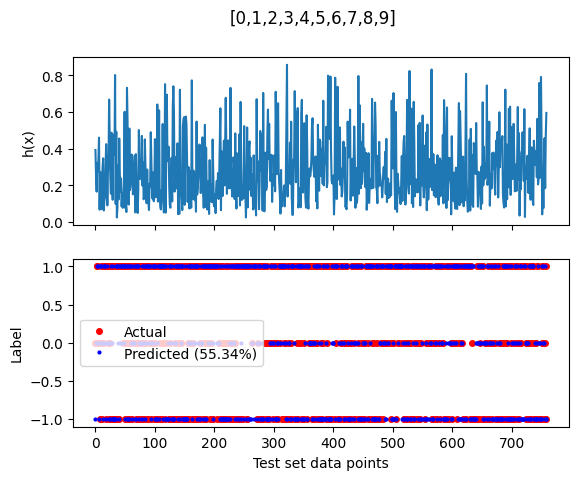

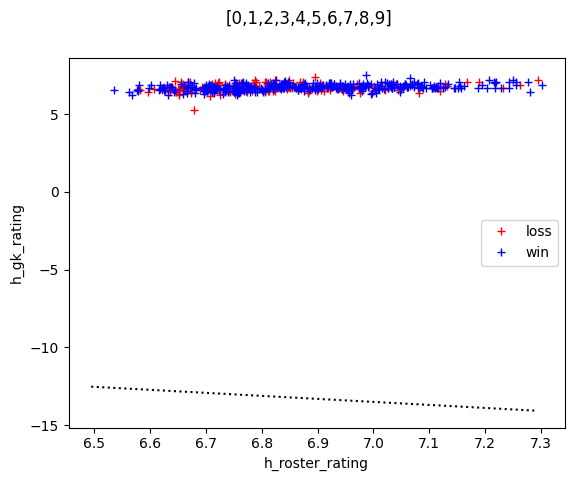

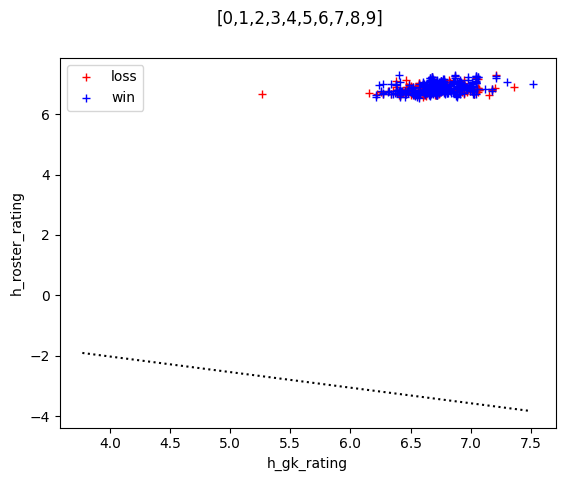

In [18]:
y_test_full, y_pred_full = do_logreg(data, list(range(0, 10)), trained=False, save_plot=True, eps=1e-10, alpha=1e-6, lmda=1e1)


Running logistic regression on features [0, 5]
Label mapping draw_is_loss=True for features=[0, 5] with ratio=0.8
Mapping draw as loss
x_train shape: (3032, 3), y_train shape: (3032,), x_test shape: (759, 3), y_test shape: (759,)
Label mapping draw_is_loss=False for features=[0, 5] with ratio=0.8
Mapping draw as win
x_train shape: (3032, 3), y_train shape: (3032,), x_test shape: (759, 3), y_test shape: (759,)
y_train sample (draw as loss): [1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1.
 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1.
 1. 1.]
y_train sample (draw as win): [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
Iteration 10000: norm diff 8.320616292792186e-05
Iteration 20000: norm diff 6.262313679946107e-05
Iteration 30000: norm diff 4.7431360378018016e-05
Iteration 40000: norm diff 3.61413825522853e-05
Iteration 50000: norm 

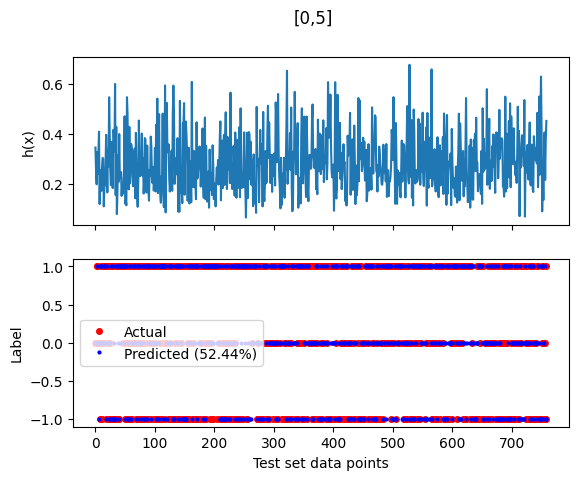

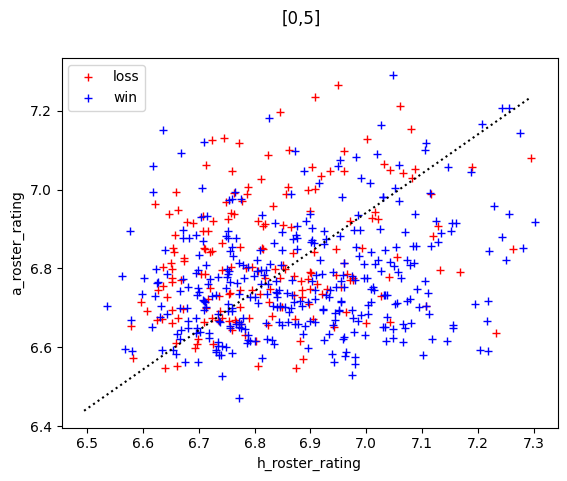

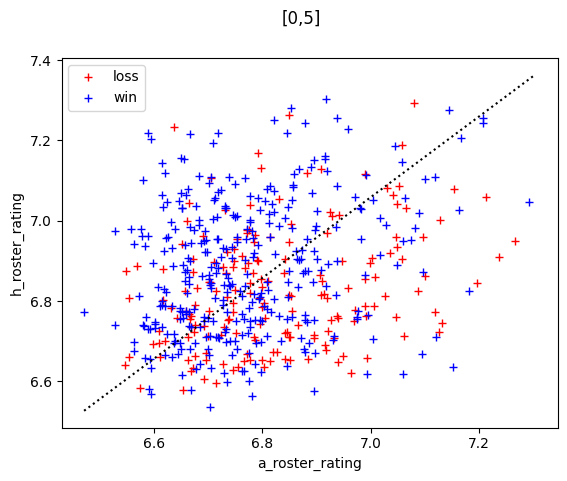

In [19]:
y_test_small, y_pred_small = do_logreg(data, [0,5], trained=False, save_plot=True, eps=1e-10, alpha=1e-6, lmda=1e1)


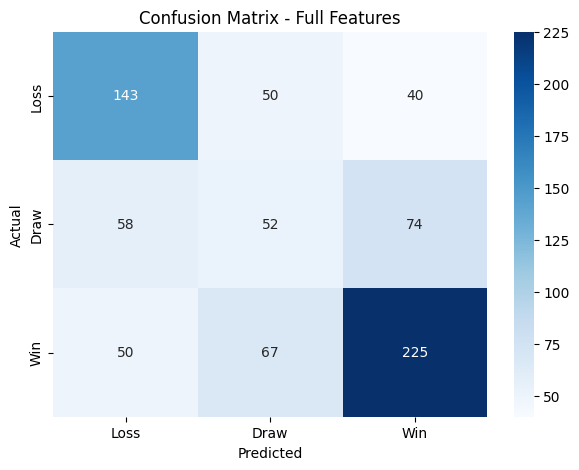

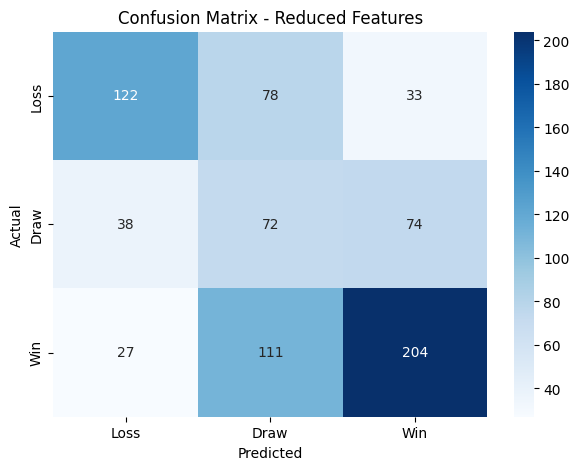

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, labels, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

# Use for full and reduced feature models:
plot_confusion_matrix(y_test_full, y_pred_full, labels=['Loss', 'Draw', 'Win'], title='Confusion Matrix - Full Features')
plot_confusion_matrix(y_test_small, y_pred_small, labels=['Loss', 'Draw', 'Win'], title='Confusion Matrix - Reduced Features')


In [21]:
from sklearn.metrics import classification_report

print("Classification Report - Full Features")
print(classification_report(y_test_full, y_pred_full, target_names=['Loss', 'Draw', 'Win'], zero_division=0))

print("Classification Report - Reduced Features")
print(classification_report(y_test_small, y_pred_small, target_names=['Loss', 'Draw', 'Win'], zero_division=0))


Classification Report - Full Features
              precision    recall  f1-score   support

        Loss       0.57      0.61      0.59       233
        Draw       0.31      0.28      0.29       184
         Win       0.66      0.66      0.66       342

    accuracy                           0.55       759
   macro avg       0.51      0.52      0.52       759
weighted avg       0.55      0.55      0.55       759

Classification Report - Reduced Features
              precision    recall  f1-score   support

        Loss       0.65      0.52      0.58       233
        Draw       0.28      0.39      0.32       184
         Win       0.66      0.60      0.62       342

    accuracy                           0.52       759
   macro avg       0.53      0.50      0.51       759
weighted avg       0.56      0.52      0.54       759



In [22]:
print("Summary Metrics - Full Features")
print_evaluation_metrics(y_test_full, y_pred_full)

print("\nSummary Metrics - Reduced Features")
print_evaluation_metrics(y_test_small, y_pred_small)


Summary Metrics - Full Features

===== Evaluation Metrics =====
Accuracy: 55.34%
Precision: 0.55
Recall: 0.55
F1 Score: 0.55
Confusion Matrix:
[[143  50  40]
 [ 58  52  74]
 [ 50  67 225]]

Summary Metrics - Reduced Features

===== Evaluation Metrics =====
Accuracy: 52.44%
Precision: 0.56
Recall: 0.52
F1 Score: 0.54
Confusion Matrix:
[[122  78  33]
 [ 38  72  74]
 [ 27 111 204]]
